# Keras Backend

In this notebook we will be using the [Keras backend module](http://keras.io/backend/), which provides an abstraction over both Theano and Tensorflow.

In [1]:
#load watermark
%load_ext watermark
%watermark -a 'Gopala KR' -u -d -v -p watermark,numpy,pandas,matplotlib,nltk,sklearn,tensorflow,theano,mxnet,chainer,seaborn,keras,tflearn,bokeh,gensim

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Using TensorFlow backend.
/srv/venv/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Gopala KR 
last updated: 2018-02-18 

CPython 3.5.3
IPython 6.2.1

watermark 1.6.0
numpy 1.13.3
pandas 0.22.0
matplotlib 2.1.2
nltk 3.2.5
sklearn 0.19.1
tensorflow 1.5.0
theano 1.0.1
mxnet 1.0.0
chainer 3.3.0
seaborn 0.8.1
keras 2.1.4
tflearn n
bokeh 0.12.14
gensim 3.3.0


/srv/venv/lib/python3.5/site-packages/scipy/sparse/sparsetools.py:20: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


Let's try to re-implement the Logistic Regression Model using the `keras.backend` APIs.

The following code will look like very similar to what we would write in Theano or Tensorflow (with the *only difference* that it may run on both the two backends).

In [2]:
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from kaggle_data import load_data, preprocess_data, preprocess_labels

In [4]:
X_train, labels = load_data('../data/kaggle_ottogroup/train.csv', train=True)
X_train, scaler = preprocess_data(X_train)
Y_train, encoder = preprocess_labels(labels)

X_test, ids = load_data('../data/kaggle_ottogroup/test.csv', train=False)

X_test, _ = preprocess_data(X_test, scaler)

nb_classes = Y_train.shape[1]
print(nb_classes, 'classes')

dims = X_train.shape[1]
print(dims, 'dims')

9 classes
93 dims


In [5]:
feats = dims
training_steps = 25

In [6]:
x = K.placeholder(dtype="float", shape=X_train.shape) 
target = K.placeholder(dtype="float", shape=Y_train.shape)

# Set model weights
W = K.variable(np.random.rand(dims, nb_classes))
b = K.variable(np.random.rand(nb_classes))

In [7]:
# Define model and loss
y = K.dot(x, W) + b
loss = K.categorical_crossentropy(y, target)

/srv/venv/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [8]:
activation = K.softmax(y) # Softmax

/srv/venv/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [9]:
lr = K.constant(0.01)
grads = K.gradients(loss, [W,b])
updates = [(W, W-lr*grads[0]), (b, b-lr*grads[1])]

/srv/venv/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


In [10]:
train = K.function(inputs=[x, target], outputs=[loss], updates=updates)

In [11]:
# Training
loss_history = []
for epoch in range(training_steps):
    current_loss = train([X_train, Y_train])[0]
    loss_history.append(current_loss)
    if epoch % 20 == 0:
        print("Loss: {}".format(current_loss))

Loss: [  549.57489014 -1016.66247559  -635.69256592 ...,  -920.59985352
  1760.96289062  -679.42797852]
Loss: [-28703894. -26237900. -27700914. ..., -27231114. -32986646. -26471550.]


In [12]:
loss_history = [np.mean(lh) for lh in loss_history]

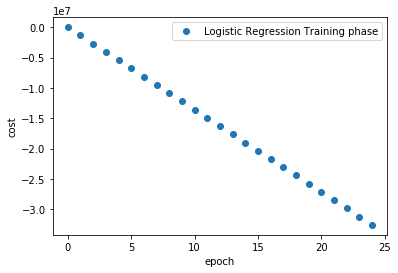

In [13]:
# plotting
plt.plot(range(len(loss_history)), loss_history, 'o', label='Logistic Regression Training phase')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Your Turn

Please switch to the **Theano** backend and **restart** the notebook.

You _should_ see no difference in the execution!

**Reminder**: please keep in mind that you *can* execute shell commands from a notebook (pre-pending a `!` sign).
Thus:

```shell
    !cat ~/.keras/keras.json
```
should show you the content of your keras configuration file.

In [14]:
!cat ~/.keras/keras.json

{
    "epsilon": 1e-07,
    "backend": "tensorflow",
    "image_data_format": "channels_last",
    "floatx": "float32"
}

### Moreover

Try to play a bit with the **learning reate** parameter to see how the loss history floats... 

---

## Exercise: Linear Regression
To get familiar with automatic differentiation, we start by learning a simple linear regression model using Stochastic Gradient Descent (SGD).

Recall that given a dataset $\{(x_i, y_i)\}_{i=0}^N$, with $x_i, y_i \in \mathbb{R}$, the objective of linear regression is to find two scalars $w$ and $b$ such that $y = w\cdot x + b$ fits the dataset. In this tutorial we will learn $w$ and $b$ using SGD and a Mean Square Error (MSE) loss:

$$\mathcal{l} = \frac{1}{N} \sum_{i=0}^N (w\cdot x_i + b - y_i)^2$$

Starting from random values, parameters $w$ and $b$ will be updated at each iteration via the following rule:

$$w_t = w_{t-1} - \eta \frac{\partial \mathcal{l}}{\partial w}$$
<br>
$$b_t = b_{t-1} - \eta \frac{\partial \mathcal{l}}{\partial b}$$

where $\eta$ is the learning rate.

**NOTE:** Recall that **linear regression** is indeed a **simple neuron** with a linear activation function!!

### Definition: Placeholders and Variables

First of all, we define the necessary variables and placeholders for our computational graph. Variables maintain state across executions of the computational graph, while placeholders are ways to feed the graph with external data.

For the linear regression example, we need three variables: `w`, `b`, and the learning rate for SGD, `lr`. 

Two placeholders `x` and `target` are created to store $x_i$ and $y_i$ values.

In [17]:
# Placeholders and variables
x = K.placeholder()
target = K.placeholder()
w = K.variable(np.random.rand())
b = K.variable(np.random.rand())

#### Notes:

In case you're wondering what's the difference between a **placeholder** and a **variable**, in short:

* Use `K.variable()` for trainable variables such as weights (`W`) and biases (`b`) for your model.
* Use `K.placeholder()` to feed actual data (e.g. training examples)

## Model definition
Now we can define the $y = w\cdot x + b$ relation as well as the MSE loss in the computational graph.

In [18]:
# Define model and loss

In [19]:
# %load ../solutions/sol_2311.py
y = w * x + b
loss = K.mean(K.square(y-target))

/srv/venv/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Then, given the gradient of MSE wrt to `w` and `b`, we can define how we update the parameters via SGD:

In [20]:
# %load ../solutions/sol_2312.py
grads = K.gradients(loss, [w,b])
updates = [(w, w-lr*grads[0]), (b, b-lr*grads[1])]

/srv/venv/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  if d.decorator_argspec is not None), _inspect.getargspec(target))


The whole model can be encapsulated in a `function`, which takes as input `x` and `target`, returns the current loss value and updates its parameter according to `updates`.

In [21]:
train = K.function(inputs=[x, target], outputs=[loss], updates=updates)

## Training
Training is now just a matter of calling the `function` we have just defined. Each time `train` is called, indeed, `w` and `b` will be updated using the SGD rule.

Having generated some random training data, we will feed the `train` function for several epochs and observe the values of `w`, `b`, and loss.

In [22]:
# Generate data
np_x = np.random.rand(1000)
np_target = 0.96*np_x + 0.24

In [23]:
# Training
loss_history = []
for epoch in range(200):
    current_loss = train([np_x, np_target])[0]
    loss_history.append(current_loss)
    if epoch % 20 == 0:
        print("Loss: %.03f, w, b: [%.02f, %.02f]" % (current_loss, K.eval(w), K.eval(b)))

Loss: 0.149, w, b: [0.18, 0.95]
Loss: 0.093, w, b: [0.15, 0.85]
Loss: 0.072, w, b: [0.15, 0.79]
Loss: 0.063, w, b: [0.15, 0.75]
Loss: 0.057, w, b: [0.17, 0.72]
Loss: 0.054, w, b: [0.18, 0.70]
Loss: 0.051, w, b: [0.20, 0.68]
Loss: 0.048, w, b: [0.21, 0.66]
Loss: 0.046, w, b: [0.23, 0.65]
Loss: 0.043, w, b: [0.25, 0.64]


We can also plot the loss history:

In [ ]:
# Plot loss history

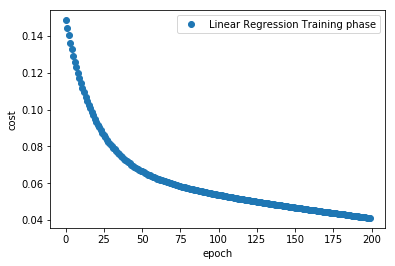

In [24]:
# %load ../solutions/sol_2313.py
plt.plot(range(len(loss_history)), loss_history, 'o', label='Linear Regression Training phase')
plt.ylabel('cost')
plt.xlabel('epoch')
plt.legend()
plt.show()

### Final Note:

Please switch back your backend to `tensorflow` before moving on. It may be useful for next notebooks !-)